In [430]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
import scipy as scipy
from scipy.optimize import minimize

YEAR = 15
UPPER_BOUND = 0.7

In [431]:
endDate = dt.datetime.today() + dt.timedelta(hours = 9) #한국 시간 기준
startDate = endDate - dt.timedelta(days = 365 * YEAR)

tickers = ['SPY', 'SCHD', 'QQQ']
# tickers = ['SPY', 'SCHD', 'QQQ', 'AAPL', 'MSFT', 'NVDA', 'GOOG', 'AMZN', 'META', 'BRK-B', 'AVGO', 'TSM', 'WMT', 'LLY', 'JPM']

In [432]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Close']

print(adj_close_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                   SPY       SCHD         QQQ
Date                                         
2010-05-10   88.272224        NaN   41.707703
2010-05-11   88.021454        NaN   41.664066
2010-05-12   89.252541        NaN   42.449829
2010-05-13   88.143036        NaN   41.777554
2010-05-14   86.547188        NaN   40.974308
...                ...        ...         ...
2025-04-29  554.320007  25.889999  475.529999
2025-04-30  554.539978  25.820000  475.470001
2025-05-01  558.469971  25.709999  481.679993
2025-05-02  566.760010  26.059999  488.829987
2025-05-05  563.510010  25.799999  485.929993

[3771 rows x 3 columns]


In [433]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns = log_returns.dropna()

In [434]:
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

           SPY      SCHD       QQQ
SPY   0.029172  0.024385  0.033115
SCHD  0.024385  0.024895  0.024633
QQQ   0.033115  0.024633  0.043409


In [435]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [436]:
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean() * weights)*252

In [437]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return (weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

In [ ]:
from fredapi import Fred
# https://fredaccount.stlouisfed.org/apikey
fred = Fred(api_key = '')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_treasury_rate[-1]
# print(risk_free_rate)

/tmp/ipykernel_23527/1429742868.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_free_rate = ten_year_treasury_rate[-1]


In [439]:
#핵심
#OPTIMIZE the portfolio using different techniques here like
# monte carlo simulation, mathematical optimization, etc
# other alternatives include black-litterman model, min variance, 
# max diversification/risk pairty, 

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, UPPER_BOUND) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

In [440]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [441]:
optimal_weights = optimized_results.x #.x gets the results

In [442]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.3000
SCHD: 0.0000
QQQ: 0.7000
Expected Annual Return: 0.1573
Expected Volatility: 0.1944
Sharpe Ratio: 0.5888


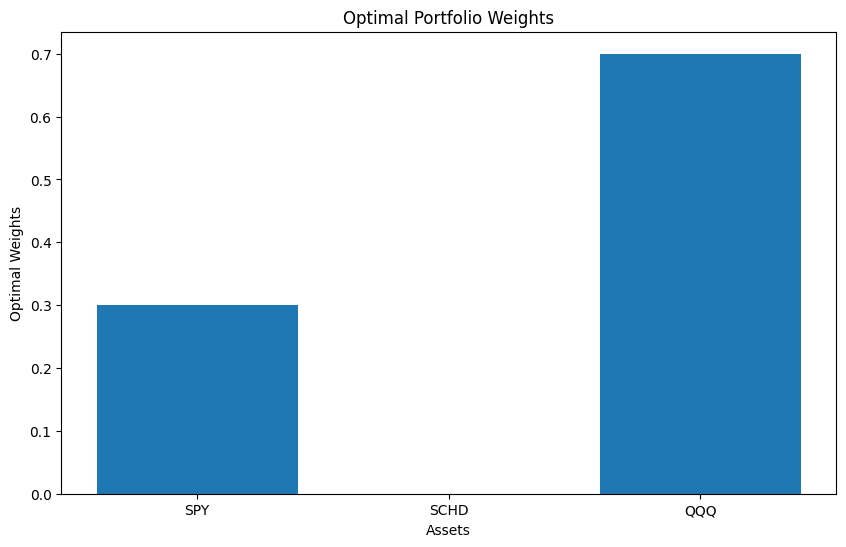

In [443]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()